# Import des Bibliothèques et Chargement des Données
Importation des bibliothèques nécessaires (pandas, numpy, sklearn, matplotlib, shap, lime, etc.) et chargement des données des statistiques d'équipes et des résultats de matchs.

In [64]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
import shap
import xgboost as xgb

train_home_team_statistics_df = pd.read_csv('./data/Train_data/train_home_team_statistics_df.csv', index_col=0)
train_away_team_statistics_df = pd.read_csv('./data/Train_data/train_away_team_statistics_df.csv', index_col=0)

train_scores = pd.read_csv("./data/Y_train.csv", index_col=0)

train_home = train_home_team_statistics_df.iloc[:,2:]
train_away = train_away_team_statistics_df.iloc[:,2:]

train_home.columns = 'HOME_' + train_home.columns
train_away.columns = 'AWAY_' + train_away.columns

train_data =  pd.concat([train_home,train_away],join='inner',axis=1)
train_scores = train_scores.loc[train_data.index]

train_data = train_data.replace({np.inf:np.nan,-np.inf:np.nan})

train_new_y = train_scores[['HOME_WINS', 'DRAW', 'AWAY_WINS']]

X_train, X_test, y_train, y_test = model_selection.train_test_split(train_data, train_new_y, train_size=0.8, random_state=42) # 80% train, 20% test
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_train, y_train, train_size=0.8, random_state=42) # 80% train, 20% valid



# XGBoost naïf
Développement et évaluation de modèles inheremment interprétables comme la régression logistique, les arbres de décision et les règles de décision.

In [65]:
# Convert multi-class labels to single-class indices
label_mapping = {'HOME_WINS': 0, 'DRAW': 1, 'AWAY_WINS': 2}
y_train_single = y_train.idxmax(axis=1).map(label_mapping)  # Map string labels to numerical values
y_test_single = y_test.idxmax(axis=1).map(label_mapping)

# XGBoost
model = xgb.XGBClassifier(n_estimators=1000, random_state=42)
model.fit(X_train, y_train_single)

y_pred = model.predict(X_test)

## feature importance de XGB

XGBoost évalue l'importance des caractéristiques en mesurant la réduction de la perte qu'elles apportent lors des divisions dans les arbres, ainsi que leur fréquence d'utilisation et l'impact sur les observations.

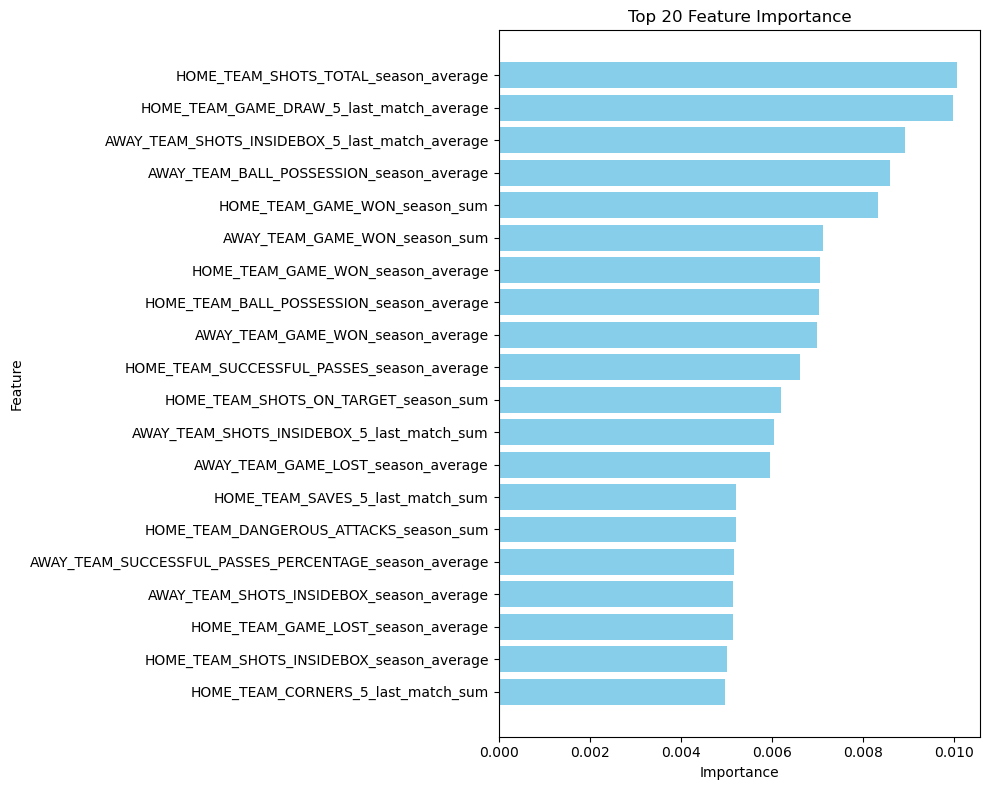

In [66]:
# Obtenir l'importance des caractéristiques
importance = model.feature_importances_
features = X_train.columns

# Créer un DataFrame pour visualiser l'importance des caractéristiques
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Limiter aux 20 caractéristiques les plus importantes
top_features = importance_df.head(20)

# Tracer l'importance des caractéristiques
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importance')
plt.gca().invert_yaxis()  # Inverser l'ordre pour afficher les plus importantes en haut
plt.tight_layout()
plt.show()

Ici plus une feature est importante plus elle réduit la "perte" du model. C'est-à-dire que plus il utilise cette valeur moins il se trompe.

Par exemple ici les caractéristiques liées aux actions offensives (tirs, possession, passes) sont très importantes. Et les caractéristiques de l'équipe à domicile semblent légèrement plus influentes que celles de l'équipe à l'extérieur, ce qui pourrait refléter un avantage du terrain qui se confirme par l'experience (les équipes a domicile gagne plus en générale).

Nous allons maintenant tenter de confirmer ces résultats avec d'autre méthode

## SHAP
SHAP est une méthode qui utilise la théorie des jeux pour expliquer les prédictions d'un modèle

In [67]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Visualiser
shap.summary_plot(shap_values, X_test)
plt.gcf().subplots_adjust(bottom=0.05, left=0.05, right=0.95, top=0.95)

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

De même ici plus la valeur est haute dans plus elle influence le model.

Le plus impactant semble toujours être le total de tire de l'équipe a domicile (a quelle point elle se créée des ocasions), on notera aussi que le nombre de match perdu par l'équipe exterieur sort du lot. Les autres features semblent-elles sont serré quant a lors importance.

Les résultats de XGBoost et SHAP mettent en lumière des caractéristiques clés influençant les prédictions du modèle, avec des similitudes et des différences notables. Les deux méthodes s'accordent sur l'importance des tirs totaux de l'équipe à domicile, soulignant son rôle crucial dans les prédictions. Cependant, XGBoost se concentre davantage sur des aspects globaux comme les matchs nuls récents et la possession de balle, tandis que SHAP offre une vue plus détaillée, montrant comment chaque caractéristique influence les différentes classes de résultats. Ensemble, ces méthodes fournissent une compréhension complète, XGBoost donnant une vue d'ensemble et SHAP une analyse granulaire des impacts spécifiques.

## LOFO
Leave One Feature Out: on retire une feature pour voir l'impact sur la précision

In [68]:
from sklearn.metrics import accuracy_score

def evaluate_model_without_feature(X_train, X_test, y_train, y_test, feature_to_exclude):
    # Exclure la caractéristique
    X_train_reduced = X_train.drop(columns=[feature_to_exclude])
    X_test_reduced = X_test.drop(columns=[feature_to_exclude])

    # Entraîner le modèle
    model = xgb.XGBClassifier(random_state=42)
    model.fit(X_train_reduced, y_train)

    # Prédire et évaluer
    y_pred = model.predict(X_test_reduced)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

# Liste des caractéristiques
features = ['HOME_TEAM_SHOTS_TOTAL_season_average',
 'HOME_TEAM_GAME_DRAW_5_last_match_average',
 'AWAY_TEAM_SHOTS_INSIDEBOX_5_last_match_average',
 'AWAY_TEAM_BALL_POSSESSION_season_average',
 'HOME_TEAM_GAME_WON_season_sum',
 'AWAY_TEAM_GAME_WON_season_sum',
 'HOME_TEAM_GAME_WON_season_average',
 'HOME_TEAM_BALL_POSSESSION_season_average',
 'AWAY_TEAM_GAME_WON_season_average',
 'HOME_TEAM_SUCCESSFUL_PASSES_season_average',
 'HOME_TEAM_SHOTS_ON_TARGET_season_sum',
 'AWAY_TEAM_SHOTS_INSIDEBOX_5_last_match_sum',
 'AWAY_TEAM_GAME_LOST_season_average',
 'HOME_TEAM_SAVES_5_last_match_sum',
 'HOME_TEAM_DANGEROUS_ATTACKS_season_sum',
 'AWAY_TEAM_SUCCESSFUL_PASSES_PERCENTAGE_season_average',
 'AWAY_TEAM_SHOTS_INSIDEBOX_season_average',
 'HOME_TEAM_GAME_LOST_season_average',
 'HOME_TEAM_SHOTS_INSIDEBOX_season_average',
 'HOME_TEAM_CORNERS_5_last_match_sum']

# Évaluer le modèle sans chaque caractéristique
accuracies = {}
for feature in features:
    accuracy = evaluate_model_without_feature(X_train, X_test, y_train, y_test, feature)
    accuracies[feature] = accuracy

# Accuracy de base
base_accuracy = accuracy_score(y_test, model.predict(X_test))

# Afficher les résultats
accuracies_df = pd.DataFrame(list(accuracies.items()), columns=['Feature', 'Accuracy'])
accuracies_df = accuracies_df.sort_values(by='Accuracy', ascending=False)
print(accuracies_df)

ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

# LIME

On va maintenant utiliser LIME pour expliquer les prédictions du modèle XGBoost, on va d'abord le faire sur une seule instance 

In [ ]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np


X_train_np = X_train.values  


X_train_filtered = X_train


X_train_filtered = X_train_filtered.fillna(X_train_filtered.mean())

print("Shape après nettoyage:", X_train_filtered.shape)


lime_explainer = LimeTabularExplainer(
    X_train_filtered.values,
    feature_names=X_train_filtered.columns.tolist(),
    class_names=['HOME_WINS', 'DRAW', 'AWAY_WINS'],
    mode='classification'
)


instance = np.array(X_train_filtered.iloc[0])

exp = lime_explainer.explain_instance(
    instance.flatten(),  
    model.predict_proba,  
)

exp.show_in_notebook()


Shape après nettoyage: (7873, 280)


On ne voit pas réellement de tendances, essayons d'afficher les poids donnés par LIME

Poids des caractéristiques pour la classe 'DRAW':
HOME_TEAM_SHOTS_TOTAL_season_sum: -0.0603
HOME_TEAM_SHOTS_INSIDEBOX_season_sum: 0.0593
HOME_TEAM_SHOTS_OFF_TARGET_season_sum: 0.0550
HOME_TEAM_SHOTS_ON_TARGET_season_sum: 0.0542
HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum: 0.0459
HOME_TEAM_PASSES_season_sum: -0.0436
HOME_TEAM_SUCCESSFUL_PASSES_season_sum: -0.0336
HOME_TEAM_SAVES_season_sum: 0.0333
HOME_TEAM_CORNERS_season_sum: 0.0331
HOME_TEAM_FOULS_season_sum: -0.0282


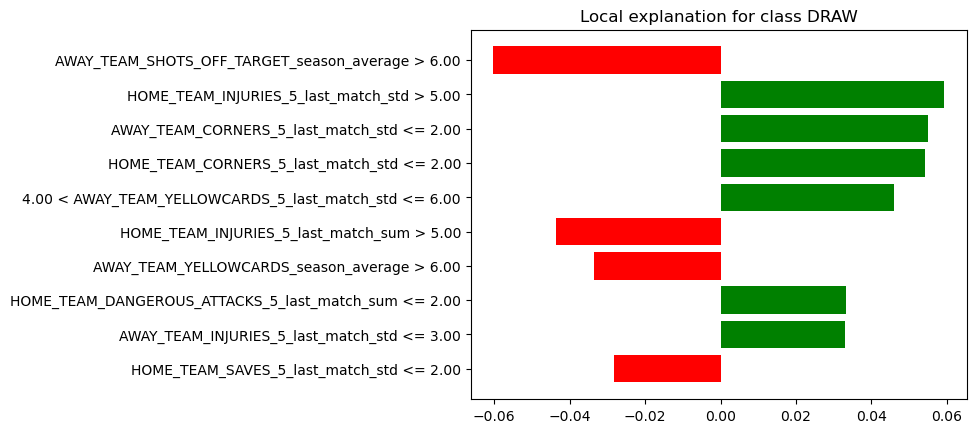

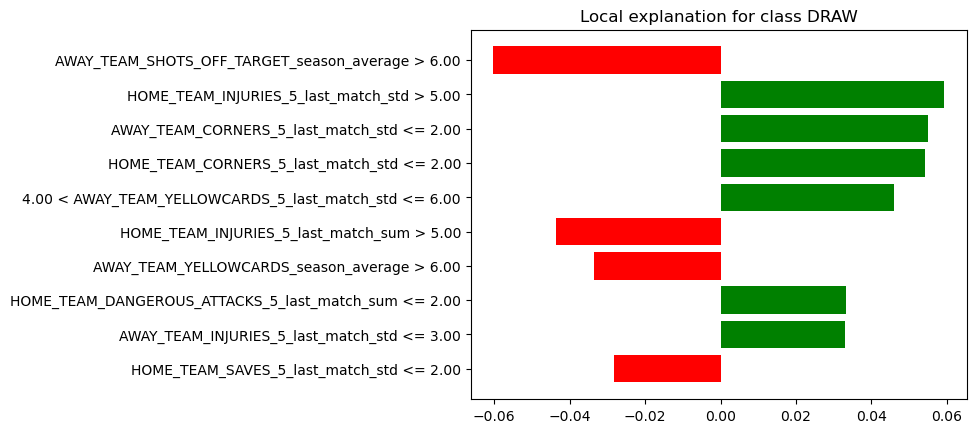

In [70]:
exp_weights = [x[1] for x in exp.as_map()[1]]

print("Poids des caractéristiques pour la classe 'DRAW':")
for feature, weight in zip(X_train_filtered.columns, exp_weights):
    print(f"{feature}: {weight:.4f}")

# Visualiser l'explication
exp.as_pyplot_figure()


Testons ça sur plusieurs instances pour avoir une vue plus globale

In [ ]:
def return_weights(exp):
    exp_map = exp.as_map()[1]
    exp_list = sorted(exp_map, key=lambda x: x[0])
    weights = [x[1] for x in exp_list]
    return weights

weights = []
for x in X_train_filtered.values[0:100]:
  
    exp = lime_explainer.explain_instance(
        x.flatten(),  
        model.predict_proba,  
        num_features=280
    )
    weights.append(return_weights(exp))

lime_weights = pd.DataFrame(data=weights, columns=X_train_filtered.columns.tolist())


In [72]:
print(lime_weights.shape)

(100, 280)


On affiche ensuite les features les plus importante selon LIME

Text(0.5, 1.0, 'Top 50 Feature Importance')

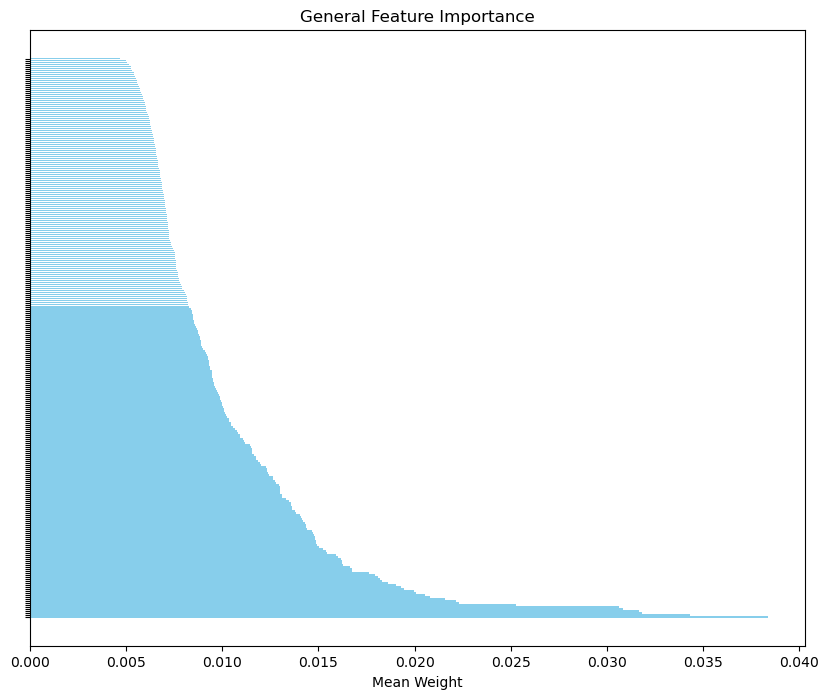

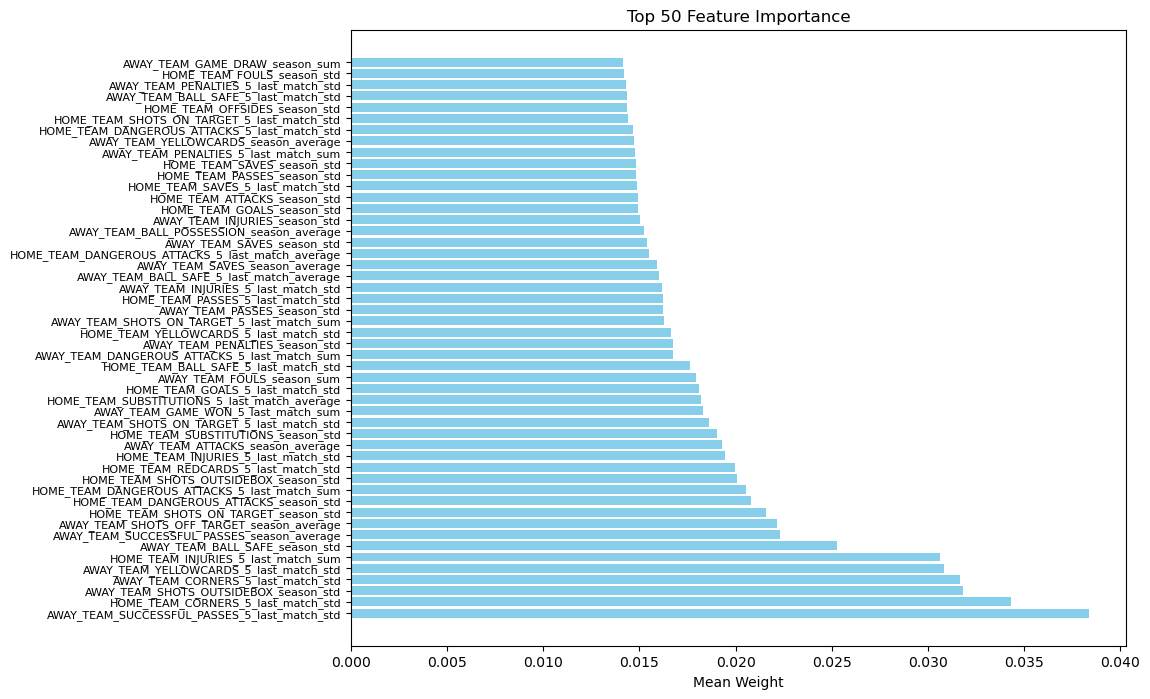

In [79]:
abs_mean = lime_weights.abs().mean(axis=0)
abs_mean = pd.DataFrame(data={'feature': abs_mean.index, 'Mean_Weight': abs_mean.values})
abs_mean = abs_mean.sort_values(by='Mean_Weight', ascending=False)
abs_mean_50 = abs_mean.head(50)

fig, ax =  plt.subplots(nrows = 1, ncols= 1,figsize=(10, 8))
y_t = range(len(abs_mean))
y_labels = abs_mean.feature 

plt.barh(y_t, abs_mean.Mean_Weight, color='skyblue')
plt.yticks(y_t, pd.Series(), size=8)
plt.xlabel('Mean Weight')
plt.title('General Feature Importance')

# nouvelle figure avec les 50 plus importantes
fig, ax =  plt.subplots(nrows = 1, ncols= 1,figsize=(10, 8))
y_t = range(len(abs_mean_50))
y_labels = abs_mean_50.feature
plt.barh(y_t, abs_mean_50.Mean_Weight, color='skyblue')
plt.yticks(y_t, abs_mean_50.feature, size=8)
plt.xlabel('Mean Weight')
plt.title('Top 50 Feature Importance')




Tentons de voir si on peut observer une corrélation

most impactful feature AWAY_TEAM_SUCCESSFUL_PASSES_5_last_match_std


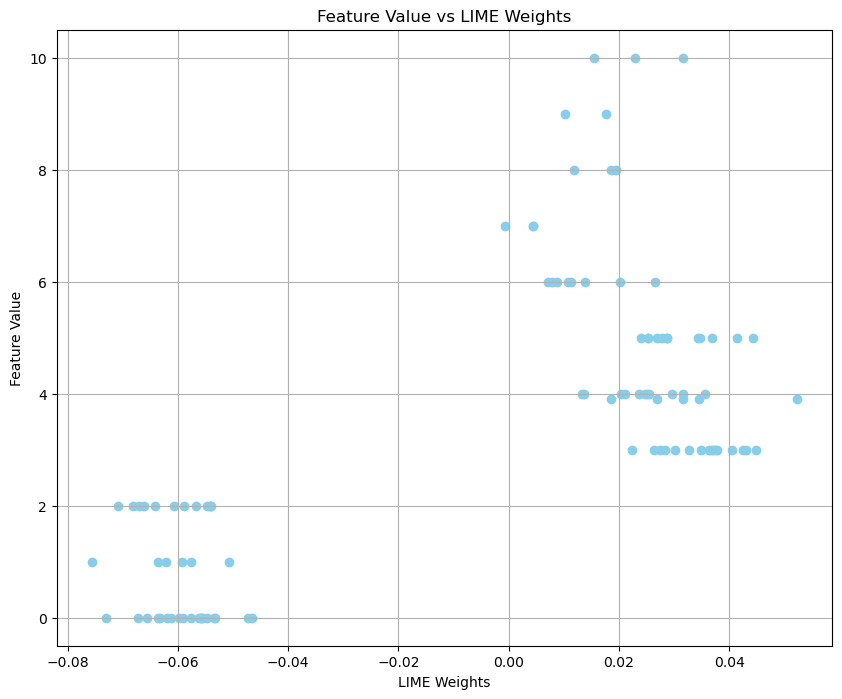

In [80]:
fig, ax =  plt.subplots(nrows = 1, ncols= 1,figsize=(10, 8))

most_impactful_feature = abs_mean.iloc[0]['feature']
print("most impactful feature", most_impactful_feature)
f_w = lime_weights[most_impactful_feature]
f_v = X_train_filtered[most_impactful_feature][0:100]

plt.scatter(f_w, f_v, color='skyblue')
plt.xlabel('LIME Weights')
plt.ylabel('Feature Value')
plt.title('Feature Value vs LIME Weights')
plt.grid()
plt.show()

Ce graphique montre la relation entre les poids de LIME pour les 50 caractéristiques les plus influentes et les valeurs réelles de ces caractéristiques pour les 100 premières instances

- L'axe X représente les poids de LIME (fw).

- L'axe Y représente la position de la caractéristique dans la liste des 50 caractéristiques.

Text(0.5, 1.0, 'Feature Value vs LIME Weights (Top 50 Features)')

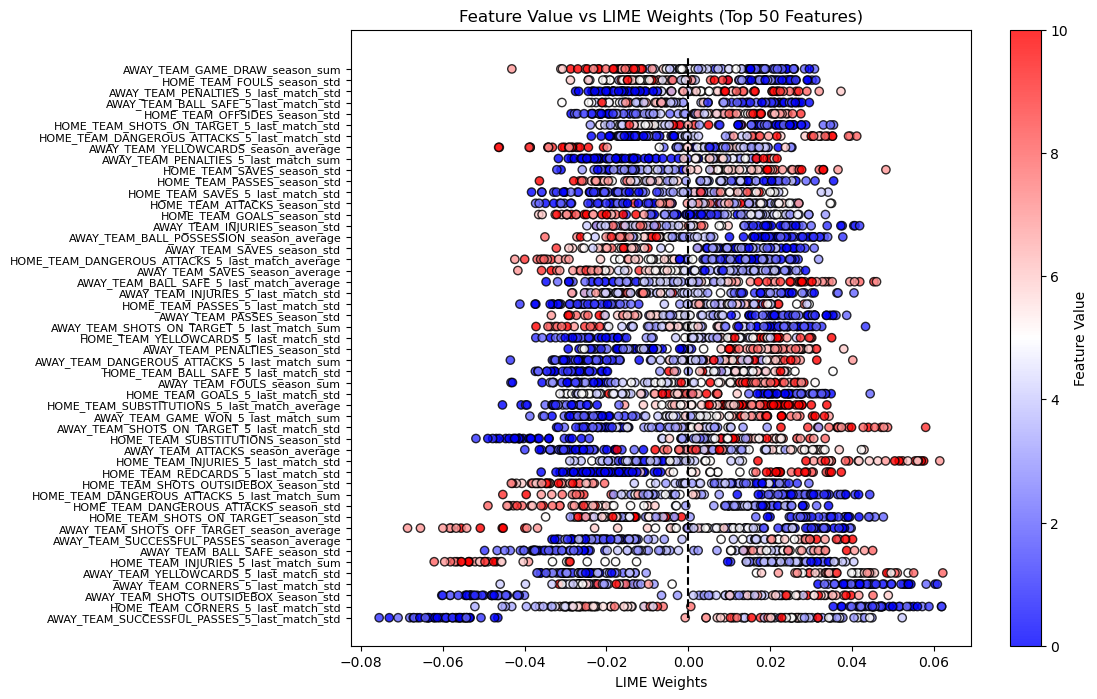

In [81]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))

# Use only the top 50 features
top_50_features = abs_mean_50['feature']
y_ticks = range(len(top_50_features))
y_labels = top_50_features

for i, feature in enumerate(y_labels):
    fw = lime_weights[feature]
    fv = X_train_filtered[feature][0:100]

    plt.scatter(fw, [i] * len(fw), c=fv, cmap='bwr', edgecolor='black', alpha=0.8)

plt.vlines(x=0, ymin=0, ymax=len(y_labels), colors='black', linestyles='dashed')
plt.colorbar(label='Feature Value')
plt.yticks(y_ticks, labels=y_labels, size=8)
plt.xlabel('LIME Weights')
plt.title('Feature Value vs LIME Weights (Top 50 Features)')